# Synthetic Experiments for DMM + KDE

This notebook implements the synthetic experiments described in the paper.

Contents
1. Setup and utilities
2. Synthetic generator for categorical blocks
3. DMM embedding + KDE classifier
4. Baselines (PCA+KNN, LDA, RandomForest)
5. Experiments S1--S4

Notes
- The goal is methodological characterization rather than leaderboard optimization.
- All runs are reproducible via fixed random seeds.


In [61]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from dataclasses import dataclass
from typing import List, Tuple, Dict, Optional

from sklearn.metrics import accuracy_score, f1_score, balanced_accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD
from sklearn.neighbors import KNeighborsClassifier, KernelDensity
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

np.random.seed(0)


In [62]:

# -----------------------------
# Utilities
# -----------------------------

def macro_f1(y_true, y_pred):
    return f1_score(y_true, y_pred, average='macro')


def evaluate_metrics(y_true, y_pred) -> Dict[str, float]:
    return {
        'accuracy': float(accuracy_score(y_true, y_pred)),
        'macro_f1': float(macro_f1(y_true, y_pred)),
        'balanced_acc': float(balanced_accuracy_score(y_true, y_pred)),
    }


def one_hot(idx: int, m: int) -> np.ndarray:
    v = np.zeros(m, dtype=np.float32)
    v[idx] = 1.0
    return v


def concat_onehots(block_indices: List[int], m_list: List[int]) -> np.ndarray:
    # block_indices[i] is the chosen modality in block i
    parts = [one_hot(block_indices[i], m_list[i]) for i in range(len(m_list))]
    return np.concatenate(parts, axis=0)


def block_offsets(m_list: List[int]) -> np.ndarray:
    # offsets for block starts in the concatenated vector
    offs = np.zeros(len(m_list) + 1, dtype=int)
    offs[1:] = np.cumsum(m_list)
    return offs


## 2. Synthetic generator: categorical blocks

We generate survey samples as concatenated one-hot blocks.
Each class has its own class-conditional categorical distributions per block.

Key controls:
- separation delta in [0, 1] for informative blocks
- high cardinality via increasing selected block sizes
- nuisance blocks (irrelevant variables)
- class imbalance


In [63]:

# -----------------------------
# Synthetic generator
# -----------------------------

@dataclass
class SyntheticConfig:
    q: int
    m_list: List[int]
    k: int
    informative_blocks: List[int]
    delta: float  # separation strength
    noise_blocks: int = 0
    seed: int = 0
    class_priors: Optional[List[float]] = None


def _peaked_distribution(m: int, peak: int, delta: float) -> np.ndarray:
    # Create a distribution concentrated at `peak`.
    # delta=0 -> uniform, delta=1 -> fully concentrated at peak.
    p = np.ones(m, dtype=np.float64) / m
    p = (1.0 - delta) * p
    p[peak] += delta
    p = p / p.sum()
    return p


def build_class_block_distributions(cfg: SyntheticConfig):
    """
    Returns:
        p: list where p[i][c] is the distribution of block i for class c
        m_list_aug: augmented m_list including noise blocks (WITHOUT mutating cfg)
        q_aug: augmented q including noise blocks (WITHOUT mutating cfg)
    """
    rng = np.random.default_rng(cfg.seed)

    # Local copies (critical!)
    q_aug = int(cfg.q)
    m_list_aug = list(cfg.m_list)

    p = []

    # Original q blocks
    for i in range(cfg.q):
        m = m_list_aug[i]
        if i in cfg.informative_blocks:
            peaks = rng.integers(low=0, high=m, size=cfg.k)
            block = [_peaked_distribution(m, int(peaks[c]), cfg.delta) for c in range(cfg.k)]
        else:
            # non-informative: identical across classes
            shared = np.ones(m, dtype=np.float64) / m
            block = [shared.copy() for _ in range(cfg.k)]
        p.append(block)

    # Add noise blocks (do NOT mutate cfg)
    for _ in range(cfg.noise_blocks):
        m = int(rng.integers(3, 10))
        shared = np.ones(m, dtype=np.float64) / m

        m_list_aug.append(m)
        q_aug += 1
        p.append([shared.copy() for _ in range(cfg.k)])

    return p, m_list_aug, q_aug

def sample_dataset(cfg: SyntheticConfig, n: int) -> Tuple[np.ndarray, np.ndarray]:
    rng = np.random.default_rng(cfg.seed + 123)

    # Class priors
    if cfg.class_priors is None:
        priors = np.ones(cfg.k) / cfg.k
    else:
        priors = np.asarray(cfg.class_priors, dtype=np.float64)
        priors = priors / priors.sum()

    # Build distributions WITHOUT mutating cfg
    p, m_list_aug, q_aug = build_class_block_distributions(cfg)

    y = rng.choice(cfg.k, size=n, p=priors)
    X = []

    for j in range(n):
        c = int(y[j])
        block_indices = []
        for i in range(q_aug):
            dist = p[i][c]
            idx = int(rng.choice(len(dist), p=dist))
            block_indices.append(idx)

        x = concat_onehots(block_indices, m_list_aug)
        X.append(x)

    X = np.vstack(X).astype(np.float32)
    return X, y.astype(int)

## 3. DMM embedding + KDE classifier

Implementation details:
- Build class-conditional count matrix F of shape (d, k)
- Amplitude lifting X = sqrt(F)
- Compute top-r eigenvectors using the small Gram matrix X^T X
- Embed samples by z = U_r^T (x / sqrt(q))
- Fit class-conditional KDEs in latent space and classify by MAP


In [64]:

# -----------------------------
# DMM embedding + KDE classifier
# -----------------------------

@dataclass
class DMMModel:
    U_r: np.ndarray            # (d, r)
    r: int
    k: int
    q: int
    bandwidth: float
    priors: np.ndarray         # (k,)
    kdes: List[KernelDensity]  # one per class


def dmm_fit(X: np.ndarray, y: np.ndarray, k: int, r: int, q: int,
            bandwidth: float = 0.3,
            use_class_normalization: bool = False) -> DMMModel:
    # X: (n, d) one-hot survey vectors
    n, d = X.shape

    # Build F: class-conditional counts
    F = np.zeros((d, k), dtype=np.float64)
    for c in range(k):
        idx = np.where(y == c)[0]
        if len(idx) == 0:
            continue
        F[:, c] = X[idx].sum(axis=0)

    # Optional class normalization (profile-based)
    if use_class_normalization:
        col_sums = F.sum(axis=0)
        col_sums[col_sums == 0] = 1.0
        F = F / col_sums

    # Amplitude lifting
    A = np.sqrt(F)

    # Gram matrix (k x k)
    G = A.T @ A

    # Eigen-decomposition of Gram matrix
    # G is symmetric PSD
    eigvals, V = np.linalg.eigh(G)
    order = np.argsort(eigvals)[::-1]
    eigvals = eigvals[order]
    V = V[:, order]

    # Keep top r components with positive eigenvalues
    eps = 1e-12
    r_eff = min(r, k)
    sig2 = eigvals[:r_eff]
    sig2 = np.maximum(sig2, eps)
    Sigma_inv = np.diag(1.0 / np.sqrt(sig2))

    U_r = (A @ V[:, :r_eff]) @ Sigma_inv  # (d, r)

    # Embed samples
    Xn = X / np.sqrt(float(q))
    Z = Xn @ U_r  # (n, r)

    # Fit KDEs per class
    kdes = []
    priors = np.zeros(k, dtype=np.float64)
    for c in range(k):
        Zc = Z[y == c]
        priors[c] = max(len(Zc), 1)
        kde = KernelDensity(kernel='gaussian', bandwidth=bandwidth)
        kde.fit(Zc)
        kdes.append(kde)

    priors = priors / priors.sum()

    return DMMModel(U_r=U_r, r=r_eff, k=k, q=q, bandwidth=bandwidth, priors=priors, kdes=kdes)


def dmm_predict(model: DMMModel, X: np.ndarray, use_priors: bool = True) -> np.ndarray:
    Xn = X / np.sqrt(float(model.q))
    Z = Xn @ model.U_r

    # Log-scores: log pi_y + log f_y(z)
    scores = np.zeros((X.shape[0], model.k), dtype=np.float64)
    for c in range(model.k):
        logp = model.kdes[c].score_samples(Z)
        if use_priors:
            logp = logp + np.log(model.priors[c] + 1e-12)
        scores[:, c] = logp

    return np.argmax(scores, axis=1)


## 4. Baselines

We include several baselines operating on the ambient one-hot space:
- PCA (TruncatedSVD) + KNN
- LDA (when feasible)
- RandomForest

These baselines are not exhaustively tuned; they serve as reference points.


In [65]:

# -----------------------------
# Baselines
# -----------------------------

def baseline_pca_knn_fit_predict(X_train, y_train, X_test, n_components=20, n_neighbors=15):
    # TruncatedSVD acts as PCA for sparse-ish data
    svd = TruncatedSVD(n_components=min(n_components, X_train.shape[1]-1), random_state=0)
    Z_train = svd.fit_transform(X_train)
    Z_test = svd.transform(X_test)

    knn = KNeighborsClassifier(n_neighbors=n_neighbors, metric='euclidean')
    knn.fit(Z_train, y_train)
    return knn.predict(Z_test)


def baseline_lda_fit_predict(X_train, y_train, X_test):
    # LDA expects dense float arrays; it may be unstable when d is huge.
    lda = LinearDiscriminantAnalysis()
    lda.fit(X_train, y_train)
    return lda.predict(X_test)


def baseline_rf_fit_predict(X_train, y_train, X_test, n_estimators=300, max_depth=None):
    rf = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        random_state=0,
        n_jobs=-1
    )
    rf.fit(X_train, y_train)
    return rf.predict(X_test)


## 5. Experiment runners

We provide helper functions to run sweeps over parameters and aggregate results.


In [66]:

# -----------------------------
# Experiment runners
# -----------------------------

def run_single_trial(cfg: SyntheticConfig,
                     n: int = 5000,
                     test_size: float = 0.3,
                     r: int = 2,
                     bandwidth: float = 0.25,
                     use_class_normalization: bool = False,
                     use_priors: bool = True,
                     baselines: bool = True,
                     seed: int = 0) -> Dict[str, Dict[str, float]]:

    cfg = SyntheticConfig(**{**cfg.__dict__, "m_list": cfg.m_list.copy()})
    cfg.seed = seed

    X, y = sample_dataset(cfg, n=n)

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=seed, stratify=y
    )

    results = {}

    # DMM + KDE
    model = dmm_fit(
        X_train, y_train,
        k=cfg.k,
        r=r,
        q=cfg.q,
        bandwidth=bandwidth,
        use_class_normalization=use_class_normalization,
    )
    y_pred = dmm_predict(model, X_test, use_priors=use_priors)
    results['DMM+KDE'] = evaluate_metrics(y_test, y_pred)

    if baselines:
        # PCA + KNN
        y_pred_pca = baseline_pca_knn_fit_predict(X_train, y_train, X_test, n_components=max(10, 5*cfg.k), n_neighbors=15)
        results['PCA+KNN'] = evaluate_metrics(y_test, y_pred_pca)

        # LDA (might fail for large d)
        try:
            y_pred_lda = baseline_lda_fit_predict(X_train, y_train, X_test)
            results['LDA'] = evaluate_metrics(y_test, y_pred_lda)
        except Exception as e:
            results['LDA'] = {'accuracy': np.nan, 'macro_f1': np.nan, 'balanced_acc': np.nan}

        # RandomForest
        y_pred_rf = baseline_rf_fit_predict(X_train, y_train, X_test)
        results['RF'] = evaluate_metrics(y_test, y_pred_rf)

    return results


def aggregate_trials(trials: List[Dict[str, Dict[str, float]]]) -> pd.DataFrame:
    rows = []
    for t in trials:
        for method, metrics in t.items():
            row = {'method': method, **metrics}
            rows.append(row)
    df = pd.DataFrame(rows)
    out = df.groupby('method').agg(['mean', 'std'])
    return out


## 6. Experiment S1: controlled separation

We vary separation delta in [0, 1] on informative blocks and report performance.


S1 results:


,delta,method,accuracy,macro_f1
0,0.0,DMM+KDE,0.344133,0.310783
1,0.0,PCA+KNN,0.344933,0.341964
2,0.0,LDA,0.334533,0.333144
3,0.0,RF,0.328133,0.325921
4,0.2,DMM+KDE,0.586000,0.584556
5,0.2,PCA+KNN,0.534000,0.532473
6,0.2,LDA,0.578133,0.578172
7,0.2,RF,0.586133,0.586124
8,0.4,DMM+KDE,0.790000,0.790123
9,0.4,PCA+KNN,0.776533,0.776139


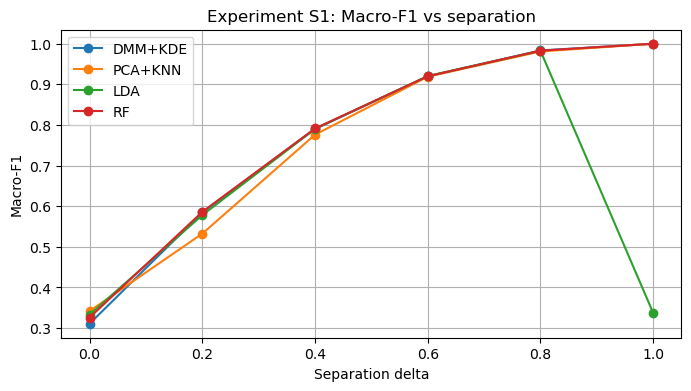

In [67]:

# -----------------------------
# Experiment S1: controlled separation
# -----------------------------

k = 3
q = 20
m_list = [6]*q
informative_blocks = list(range(5))

base_cfg = SyntheticConfig(
    q=q,
    m_list=m_list.copy(),
    k=k,
    informative_blocks=informative_blocks,
    delta=0.0,
    noise_blocks=0,
    seed=0
)

n = 5000
r = min(k, 3)

deltas = np.linspace(0.0, 1.0, 6)
methods = ['DMM+KDE', 'PCA+KNN', 'LDA', 'RF']

records = []

for delta in deltas:
    cfg = SyntheticConfig(**{**base_cfg.__dict__})
    cfg.delta = float(delta)

    trials = []
    for seed in range(5):
        res = run_single_trial(cfg, n=n, r=r, bandwidth=0.25, baselines=True, seed=seed)
        trials.append(res)

    # Aggregate
    df = aggregate_trials(trials)
    for method in methods:
        if method not in df.index:
            continue
        acc_mean = df.loc[method, ('accuracy','mean')]
        f1_mean = df.loc[method, ('macro_f1','mean')]
        records.append({'delta': delta, 'method': method, 'accuracy': acc_mean, 'macro_f1': f1_mean})

s1_df = pd.DataFrame(records)
print('S1 results:')
display(s1_df)

# Plot
fig = plt.figure(figsize=(8,4))
for method in methods:
    sub = s1_df[s1_df['method'] == method]
    if len(sub) == 0:
        continue
    plt.plot(sub['delta'], sub['macro_f1'], marker='o', label=method)

plt.xlabel('Separation delta')
plt.ylabel('Macro-F1')
plt.title('Experiment S1: Macro-F1 vs separation')
plt.grid(True)
plt.legend()
plt.show()


## 7. Experiment S2: high cardinality and sparsity

We increase the modality sizes for selected blocks, which increases d while keeping n fixed.


S2 results:


,scale,d,method,accuracy,macro_f1
0,1,75,DMM+KDE,0.979167,0.979039
1,1,75,PCA+KNN,0.978000,0.977877
2,1,75,RF,0.978000,0.977933
3,2,100,DMM+KDE,0.977333,0.977202
4,2,100,PCA+KNN,0.978667,0.978554
5,2,100,RF,0.976833,0.976741
6,4,150,DMM+KDE,0.977833,0.977701
7,4,150,PCA+KNN,0.978833,0.978718
8,4,150,RF,0.976500,0.976411
9,8,250,DMM+KDE,0.977500,0.977350


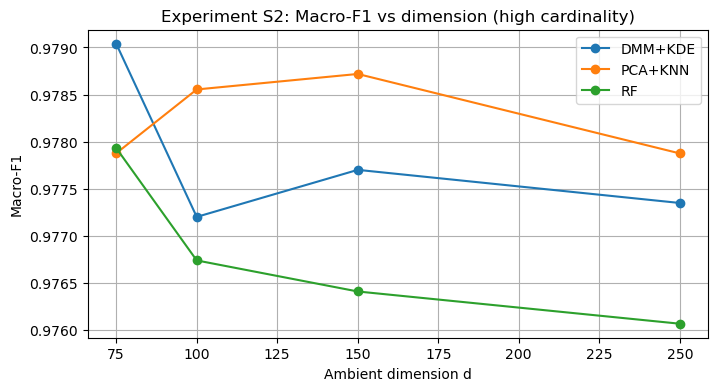

In [68]:

# -----------------------------
# Experiment S2: high cardinality and sparsity
# -----------------------------

k = 3
q = 15
base_m = 5

informative_blocks = list(range(5))

n = 4000
r = min(k, 3)

scales = [1, 2, 4, 8]
records = []

for scale in scales:
    m_list = [base_m]*q

    # Increase cardinality of a subset of variables
    for i in range(5, 10):
        m_list[i] = base_m * scale

    cfg = SyntheticConfig(
        q=q,
        m_list=m_list,
        k=k,
        informative_blocks=informative_blocks,
        delta=0.8,
        noise_blocks=0,
        seed=0
    )

    d = sum(m_list)

    trials = []
    for seed in range(5):
        res = run_single_trial(cfg, n=n, r=r, bandwidth=0.25, baselines=True, seed=seed)
        trials.append(res)

    df = aggregate_trials(trials)
    for method in ['DMM+KDE', 'PCA+KNN', 'RF']:
        acc_mean = df.loc[method, ('accuracy','mean')]
        f1_mean = df.loc[method, ('macro_f1','mean')]
        records.append({'scale': scale, 'd': d, 'method': method, 'accuracy': acc_mean, 'macro_f1': f1_mean})

s2_df = pd.DataFrame(records)
print('S2 results:')
display(s2_df)

fig = plt.figure(figsize=(8,4))
for method in ['DMM+KDE', 'PCA+KNN', 'RF']:
    sub = s2_df[s2_df['method'] == method]
    plt.plot(sub['d'], sub['macro_f1'], marker='o', label=method)

plt.xlabel('Ambient dimension d')
plt.ylabel('Macro-F1')
plt.title('Experiment S2: Macro-F1 vs dimension (high cardinality)')
plt.grid(True)
plt.legend()
plt.show()


In [69]:
print('S2 results:')
display(s2_df)


S2 results:


,scale,d,method,accuracy,macro_f1
0,1,75,DMM+KDE,0.979167,0.979039
1,1,75,PCA+KNN,0.978000,0.977877
2,1,75,RF,0.978000,0.977933
3,2,100,DMM+KDE,0.977333,0.977202
4,2,100,PCA+KNN,0.978667,0.978554
5,2,100,RF,0.976833,0.976741
6,4,150,DMM+KDE,0.977833,0.977701
7,4,150,PCA+KNN,0.978833,0.978718
8,4,150,RF,0.976500,0.976411
9,8,250,DMM+KDE,0.977500,0.977350


## 8. Experiment S3: irrelevant variables and noise robustness

We add q_noise extra blocks whose distributions are identical across classes.
We sweep the noise ratio alpha = q_noise / q.


S3 results:


,alpha,q_noise,method,accuracy,macro_f1
0,0.0,0,DMM+KDE,0.983833,0.983898
1,0.0,0,PCA+KNN,0.984667,0.984712
2,0.0,0,RF,0.983000,0.983022
3,0.5,8,DMM+KDE,0.983167,0.983246
4,0.5,8,PCA+KNN,0.982333,0.982399
5,0.5,8,RF,0.982833,0.982909
6,1.0,15,DMM+KDE,0.979000,0.979101
7,1.0,15,PCA+KNN,0.980000,0.980090
8,1.0,15,RF,0.980000,0.980060
9,2.0,30,DMM+KDE,0.983667,0.983700


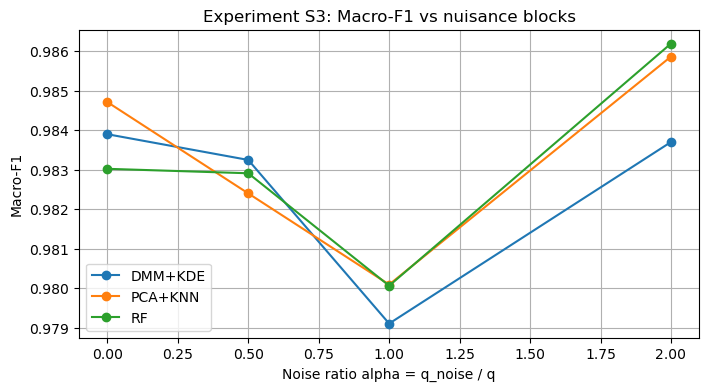

In [70]:

# -----------------------------
# Experiment S3: irrelevant variables and noise robustness
# -----------------------------

k = 3
q = 15
m_list = [6]*q
informative_blocks = list(range(5))

n = 4000
r = min(k, 3)

alphas = [0.0, 0.5, 1.0, 2.0]
records = []

for alpha in alphas:
    q_noise = int(round(alpha * q))
    cfg = SyntheticConfig(
        q=q,
        m_list=m_list.copy(),
        k=k,
        informative_blocks=informative_blocks,
        delta=0.8,
        noise_blocks=q_noise,
        seed=0
    )

    trials = []
    for seed in range(5):
        res = run_single_trial(cfg, n=n, r=r, bandwidth=0.25, baselines=True, seed=seed)
        trials.append(res)

    df = aggregate_trials(trials)
    for method in ['DMM+KDE', 'PCA+KNN', 'RF']:
        acc_mean = df.loc[method, ('accuracy','mean')]
        f1_mean = df.loc[method, ('macro_f1','mean')]
        records.append({'alpha': alpha, 'q_noise': q_noise, 'method': method, 'accuracy': acc_mean, 'macro_f1': f1_mean})

s3_df = pd.DataFrame(records)
print('S3 results:')
display(s3_df)

fig = plt.figure(figsize=(8,4))
for method in ['DMM+KDE', 'PCA+KNN', 'RF']:
    sub = s3_df[s3_df['method'] == method]
    plt.plot(sub['alpha'], sub['macro_f1'], marker='o', label=method)

plt.xlabel('Noise ratio alpha = q_noise / q')
plt.ylabel('Macro-F1')
plt.title('Experiment S3: Macro-F1 vs nuisance blocks')
plt.grid(True)
plt.legend()
plt.show()


## 9. Experiment S4: class imbalance (optional)

Binary case with imbalance ratios up to 95/5.
We compare:
- count-based operator vs class-normalized operator
- ML vs MAP decision rule (with empirical priors)

We report Balanced Accuracy and Macro-F1.


S4 results:


,p_major,p_minor,setting,balanced_acc,macro_f1
0,0.50,0.50,count_ML,0.995895,0.995888
1,0.50,0.50,count_MAP,0.995094,0.995109
2,0.50,0.50,norm_ML,0.995895,0.995888
3,0.50,0.50,norm_MAP,0.995094,0.995109
4,0.80,0.20,count_ML,0.994351,0.991741
5,0.80,0.20,count_MAP,0.930661,0.953848
6,0.80,0.20,norm_ML,0.994351,0.991741
7,0.80,0.20,norm_MAP,0.930661,0.953848
8,0.90,0.10,count_ML,0.993910,0.986778
9,0.90,0.10,count_MAP,0.788744,0.853848


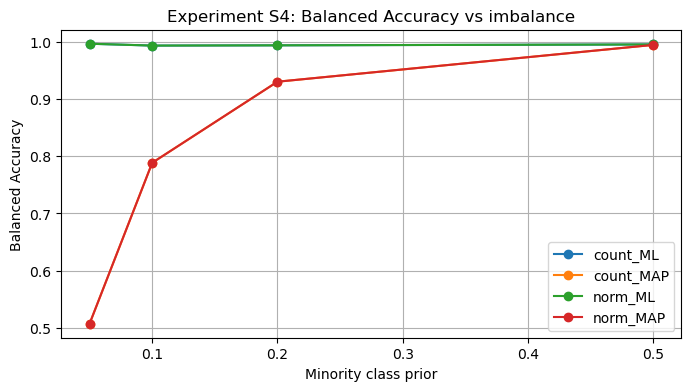

In [72]:

# -----------------------------
# Experiment S4: class imbalance
# -----------------------------

k = 2
q = 20
m_list = [6]*q
informative_blocks = list(range(6))

n = 6000
r = 2

imbalance_settings = [
    (0.50, 0.50),
    (0.80, 0.20),
    (0.90, 0.10),
    (0.95, 0.05),
]

records = []

for (p0, p1) in imbalance_settings:
    cfg = SyntheticConfig(
        q=q,
        m_list=m_list.copy(),
        k=k,
        informative_blocks=informative_blocks,
        delta=0.8,
        noise_blocks=0,
        seed=0,
        class_priors=[p0, p1]
    )

    for setting in [
        ('count_ML', False, False),
        ('count_MAP', False, True),
        ('norm_ML', True, False),
        ('norm_MAP', True, True),
    ]:
        name, use_norm, use_priors = setting

        trials = []
        for seed in range(5):
            res = run_single_trial(
                cfg,
                n=n,
                r=r,
                bandwidth=0.25,
                use_class_normalization=use_norm,
                use_priors=use_priors,
                baselines=False,
                seed=seed
            )
            trials.append(res)

        df = aggregate_trials(trials)
        bal = df.loc['DMM+KDE', ('balanced_acc','mean')]
        f1 = df.loc['DMM+KDE', ('macro_f1','mean')]
        records.append({
            'p_major': p0,
            'p_minor': p1,
            'setting': name,
            'balanced_acc': bal,
            'macro_f1': f1
        })

s4_df = pd.DataFrame(records)
print('S4 results:')
display(s4_df)

# Plot balanced accuracy
fig = plt.figure(figsize=(8,4))
for setting in s4_df['setting'].unique():
    sub = s4_df[s4_df['setting'] == setting]
    plt.plot(sub['p_minor'], sub['balanced_acc'], marker='o', label=setting)

plt.xlabel('Minority class prior')
plt.ylabel('Balanced Accuracy')
plt.title('Experiment S4: Balanced Accuracy vs imbalance')
plt.grid(True)
plt.legend()
plt.show()


## 10. Notes for paper figures and tables

- For MDPI figures, you can export plots from this notebook as PDF or PNG.
- All experiment sections generate compact DataFrames that can be used to create tables.

Typical workflow:
1. Fix a baseline configuration
2. Run a parameter sweep
3. Aggregate results over seeds
4. Export the aggregated DataFrame to CSV


In [73]:

# Example export (uncomment as needed)
# s1_df.to_csv('s1_results.csv', index=False)
# s2_df.to_csv('s2_results.csv', index=False)
# s3_df.to_csv('s3_results.csv', index=False)
# s4_df.to_csv('s4_results.csv', index=False)
